In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from torchvision.transforms import Compose, ToTensor, Normalize, Lambda, functional, CenterCrop
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import torch
from typing import List, Tuple, Any
import numpy as np
from matplotlib import pyplot as plt
import logging
from pickle import dump
from time import time

In [3]:
from biomedical_image_segmentation.utils import load_pickle
from biomedical_image_segmentation.losses.loss import MSELoss, BCELoss
from biomedical_image_segmentation.models.custom_unet import CustomUNet
from biomedical_image_segmentation.data.validator import validate 
from biomedical_image_segmentation.utils import create_dir, empty_dir

In [4]:
PROJECT_PATH = os.getcwd().replace("notebooks","")
LOG_PATH = os.path.join(PROJECT_PATH, "logs")
DATA_PATH = os.path.join(PROJECT_PATH, "data")
SAMPLES_PATH = os.path.join(DATA_PATH, "samples")
TRAIN_SAMPLES_PATH = os.path.join(SAMPLES_PATH, "train")
MASKS_PATH = os.path.join(DATA_PATH, "masks")
TRAIN_MASKS_PATH = os.path.join(MASKS_PATH, "train")

AUGMENTED_DATA_PATH = os.path.join(DATA_PATH, "augmented")
VALID_DATA_PATH = os.path.join(DATA_PATH, "valid")
TEST_DATA_PATH = os.path.join(DATA_PATH, "test")

MODEL_PATH = os.path.join(DATA_PATH, "model-weights")

MODEL_NAME = "unet-700"

SCRIPT_NAME = "model-fitting"

LOG_FILE_NAME = os.path.join(LOG_PATH, f"{SCRIPT_NAME}_{int(time())}.log")


TRAIN_BATCH_SIZE = 3
VALID_BATCH_SIZE = 1
TEST_BATCH_SIZE = 1

MIN_LOG_BATCH_WINDOW = 100

In [5]:
create_dir(LOG_PATH, True)

if os.path.basename(LOG_FILE_NAME) in os.listdir(LOG_PATH): os.remove(LOG_FILE_NAME)
    
logging.basicConfig(
    filename=LOG_FILE_NAME,
    format='%(asctime)s %(message)s',
    datefmt='%m/%d/%Y %I:%M:%S %p',
    encoding='utf-8', 
    level=logging.DEBUG)

In [6]:
logging.info(f"Creating directory: {MODEL_PATH}")
create_dir(MODEL_PATH, True)

In [7]:
logging.info("Loading train dataset")
train_dataset = []
for f in tqdm(os.listdir(path=AUGMENTED_DATA_PATH), leave=False):
    train_dataset += load_pickle(os.path.join(AUGMENTED_DATA_PATH, f))
    
logging.info("Loading valid dataset")
valid_dataset = load_pickle(os.path.join(VALID_DATA_PATH, "valid.pickle"))

logging.info("Loading test dataset")
test_dataset = load_pickle(os.path.join(TEST_DATA_PATH, "test.pickle"))

In [8]:
logging.info("Validating train dataset")
validate(train_dataset)

logging.info("Validating valid dataset")
validate(valid_dataset)

logging.info("Validating test dataset")
validate(test_dataset)

In [9]:
logging.info(f"Number of samples in train dataset: {len(train_dataset)}")
logging.info(f"Number of samples in valid dataset: {len(valid_dataset)}")
logging.info(f"Number of samples in test dataset: {len(test_dataset)}")

print(f"Number of samples in train dataset: {len(train_dataset)}")
print(f"Number of samples in valid dataset: {len(valid_dataset)}")
print(f"Number of samples in test dataset: {len(test_dataset)}")

Number of samples in train dataset: 1760
Number of samples in valid dataset: 5
Number of samples in test dataset: 5


In [10]:
LOG_BATCH_WINDOW = min(len(train_dataset) // 3 + 1, MIN_LOG_BATCH_WINDOW)

In [11]:
class CustomDataset(Dataset):
    def __init__(
      self, 
      dataset: List[Tuple[np.ndarray, np.ndarray]],
      image_transformations=None, 
      mask_transformations=None ):
        self.data = dataset
        self.image_transformations = image_transformations
        self.mask_transformations = mask_transformations

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, mask = self.data[idx]
        if self.image_transformations is not None:
            img = self.image_transformations(img)
            
        if self.mask_transformations is not None:
            mask = self.mask_transformations(mask)

        return img, mask

In [12]:
image_transformations = Compose(
    [
#         ToTensor(),
        Lambda(lambda x: torch.tensor(np.expand_dims(x, axis=0), dtype=torch.float32)),
        Lambda(lambda x: functional.pad(x, padding=94, padding_mode="reflect")),
        Normalize(mean=(0.,), std=(255.,)),
    ])

mask_transformations = Compose(
    [
#         ToTensor(),
        Lambda(lambda x: torch.tensor(np.expand_dims(x, axis=0), dtype=torch.float32)),
#         Lambda(lambda x: x.float()),
        Normalize(mean=(0.,), std=(255.,))
   ])

logging.info("Preparing train, valid and test data loaders")
logging.info(f"Batch size: train: {TRAIN_BATCH_SIZE}, "
             f"valid: {VALID_BATCH_SIZE}, test: {TEST_BATCH_SIZE}")

train_loader = DataLoader(
    dataset=CustomDataset(
        train_dataset, 
        image_transformations=image_transformations, 
        mask_transformations=mask_transformations), 
    batch_size = TRAIN_BATCH_SIZE, 
    shuffle = True)

valid_loader = DataLoader(
    dataset=CustomDataset(
        valid_dataset, 
        image_transformations=image_transformations, 
        mask_transformations=mask_transformations), 
    batch_size = VALID_BATCH_SIZE, 
    shuffle = False)

test_loader = DataLoader(
    dataset=CustomDataset(
        test_dataset, 
        image_transformations=image_transformations, 
        mask_transformations=mask_transformations), 
    batch_size = TEST_BATCH_SIZE, 
    shuffle = False)

In [13]:
logging.info("Validating masks of train, valid and test dataset")
for X, Y in tqdm(train_loader, leave=False):
    assert np.allclose(np.unique(Y), np.array([0., 1.]))

for X, Y in tqdm(valid_loader, leave=False):
    assert np.allclose(np.unique(Y), np.array([0., 1.]))
    
for X, Y in tqdm(test_loader, leave=False):
    assert np.allclose(np.unique(Y), np.array([0., 1.]))
logging.info("Validation of masks passed")

In [14]:
logging.info("Computing weights of 0 and 1 pixel values from train dataset")
weights = []
for X, Y in tqdm(train_loader, leave=False):
    weights.append(np.unique(Y, return_counts=True)[1])

weights = np.mean(np.array(weights), axis=0)
weights /= weights.sum()
weights = 1 - weights

weights = (.5, .5)
logging.info(f"Weights for pixel values 0. and 1.: {weights}")

In [15]:
logging.info("Loading model in CPU")
unet = CustomUNet()

In [16]:
EPOCHS = 10
LEARNING_RATE = 1e-4
BETAS = (.99, .999)

logging.info(f"Number of epochs: {EPOCHS}")
logging.info(f"Initial learning rate: {LEARNING_RATE: .10f}")

In [17]:
# saving at epoch level
metrics = {
    "train": {"loss": [], "pixel-error": []},
    "valid": {"loss": [], "pixel-error": []},
    "min_valid_loss": 1e10}

In [18]:
logging.info("Checking if model already exists")

if MODEL_NAME in os.listdir(MODEL_PATH):
    logging.info(f"{MODEL_NAME} already exists, loading weights")
    unet.load_state_dict(torch.load(os.path.join(MODEL_PATH, MODEL_NAME)))
    metrics = load_pickle(os.path.join(MODEL_PATH, f"{MODEL_NAME}.pickle"))
    logging.info(f"Min valid loss: {metrics['min_valid_loss']}")
else:
    logging.info(f"{MODEL_NAME} does not exists")

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.info(f"GPU available: {True if device.type == 'cuda' else False}")

unet.to(device)

logging.info("Initiating optimizer")
adam = torch.optim.Adam(unet.parameters(), lr = LEARNING_RATE, betas=BETAS)

In [20]:
t = tqdm(range(EPOCHS), leave=False)
for i in t:
    with torch.set_grad_enabled(True):
        unet.train() 
        total_loss = 0.
        n = 0
        for j, (X, Y) in enumerate(train_loader):  
            X = X.to(device)
            Y = Y.to(device)
            adam.zero_grad()
            Y_pred = unet(X)
            loss = BCELoss(weights=weights, pred=Y_pred, target=Y)
            loss.backward()
            adam.step()
            n += len(X)
            total_loss += loss.item() * len(X) 
            
            info = f"Epoch: {i}, mode: train, batch: {j}, batch_loss: {loss.item(): .5f}"
            if j % LOG_BATCH_WINDOW == 0: logging.info(info)
            t.set_description(info)
        total_loss /= n
    metrics["train"]["loss"].append(total_loss) 
    logging.info(f"Epoch: {i}, mode: train, loss: {total_loss}")
    
    with torch.set_grad_enabled(False):
        unet.eval() 
        total_loss = 0.
        n = 0
        for j, (X, Y) in enumerate(valid_loader):  
            X = X.to(device)
            Y = Y.to(device)
            Y_pred = unet(X)
            loss = BCELoss(weights=weights, pred=Y_pred, target=Y)
            n += len(X)
            total_loss += loss.item() * len(X)
            info = f"Epoch: {i}, mode: valid, batch: {j}, batch_loss: {loss.item(): .5f}"
            if j % LOG_BATCH_WINDOW == 0: logging.info(info)
            t.set_description(info)
        
        total_loss /= n
        
        if total_loss < metrics["min_valid_loss"]:
            logging.info(f"{'='*10} Updating best model weights {'='*10}")
            metrics["min_valid_loss"] = total_loss
            torch.save(unet.state_dict(), os.path.join(MODEL_PATH, MODEL_NAME))
            logging.info(f"Min valid loss: {metrics['min_valid_loss']}")
        
    metrics["valid"]["loss"].append(total_loss)        
    logging.info(f"Epoch: {i}, mode: valid, loss: {total_loss}")
    
    logging.info("Saving epoch metrics")
    with open(os.path.join(MODEL_PATH, f"{MODEL_NAME}.pickle"), "wb") as f:
        dump(metrics, f)

In [23]:
img, mask = next(iter(test_loader))

In [24]:
device = "cpu"
unet.to(device)
unet.eval()
output = unet(img.to(device)).detach()

In [25]:
def process_output(output, threshold: float=.5):
    return torch.where(torch.sigmoid(output) >= threshold, 1., 0.)

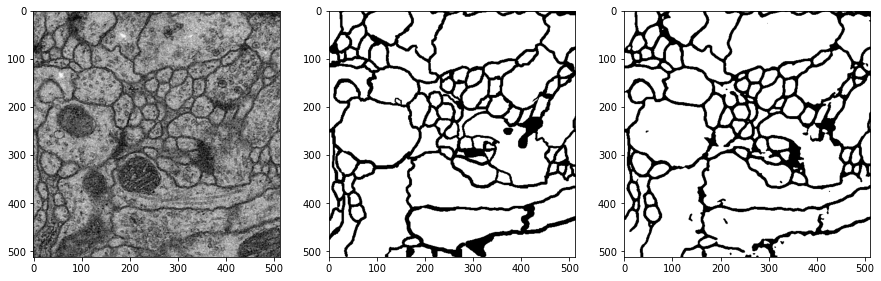

In [28]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 5))
i = 0
ax1.imshow(CenterCrop(512)(img)[i][0], cmap="gray")
ax2.imshow(mask[i][0], cmap="gray")
ax3.imshow(process_output(output)[i][0], cmap="gray")
plt.show()